In [2]:
import os
from sklearn.decomposition import FastICA, PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from osgeo import gdal
import rasterio
from scipy.interpolate import interp2d
from numpy.ma import masked_array
import glob
import h5py
from datetime import datetime, timedelta
import geopandas as gpd
from scipy.stats import linregress
from matplotlib.dates import date2num, num2date
import pandas as pd
from shapely.geometry import Point, Polygon
from rasterio.transform import from_origin
import netCDF4 as nc

# this is Andrew Watson's library of functions, see https://github.com/Active-Tectonics-Leeds/interseismic_practical
import sys
import interseis_lib as lib


In [9]:
# load files for frames

frames = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/ica_low_res_frames.txt"
cumh5_dir = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/cumh5"
mask_dir = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/mask"
EQA_dir = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/EQA.dem_par"
subs_poly_path = 'vU_merge_161023_noBabRas_WGS84_fillednosmooth_wmean_rad2_dist18_ltemin10_polygonised_dissolved.shp'

with open(frames, "r") as file:
    frames_list = file.read().splitlines()

frames_data = []

for frame in frames_list: 
    EQA_par_pattern = os.path.join(EQA_dir,f"{frame}_GEOCml*GACOSmask_EQA.dem_par")
    EQA_par_file = glob.glob(EQA_par_pattern)
    cumh5_pattern = os.path.join(cumh5_dir,f"{frame}_GEOCml*GACOSmask_cum.h5")
    cumh5_file = glob.glob(cumh5_pattern)
    mask_pattern = os.path.join(mask_dir,f"{frame}_GEOCml*GACOSmask_coh_03_mask.geo.tif")
    mask_file = glob.glob(mask_pattern)

    with h5py.File(cumh5_file[0], 'r') as file:
        imdates = file['imdates']
        imdates = imdates[:] 
        vel = file['vel']
        vel = vel[:]
        cum = file['cum']
        cum = cum[:]

    dates=[]
    for date_value in imdates:
        date_string = str(date_value)  # Convert int32 to string
        year = int(date_string[:4])
        month = int(date_string[4:6])
        day = int(date_string[6:])
        real_date = datetime(year, month, day)
        dates.append(real_date)    

    width = int(lib.get_par(EQA_par_file[0],'width'))
    length = int(lib.get_par(EQA_par_file[0],'nlines'))
    
    # get corner positions
    corner_lat = float(lib.get_par(EQA_par_file[0], 'corner_lat'))
    corner_lon = float(lib.get_par(EQA_par_file[0], 'corner_lon'))

    # get post spacing (distance between velocity measurements)
    post_lat = float(lib.get_par(EQA_par_file[0],'post_lat'))
    post_lon = float(lib.get_par(EQA_par_file[0],'post_lon'))

    # calculate grid spacings
    lat = corner_lat + post_lat*np.arange(1,length+1) - post_lat/2
    lon = corner_lon + post_lon*np.arange(1,width+1) - post_lon/2

    frames_data.append({
        'frame': frame,
        'EQA_file': EQA_par_file,
        'cumh5_file': cumh5_file,
        'mask_file': mask_file,
        'imdates': imdates,
        'vel': vel,
        'cum': cum,
        'dates': dates,
        'width': width,
        'length': length,
        'corner_lat': corner_lat,
        'corner_lon': corner_lon,
        'post_lat': post_lat,
        'post_lon': post_lon,
        'lat': lat,
        'lon': lon
            })

    # Create GeoDataFrame
    frames_gdf = gpd.GeoDataFrame(frames_data, columns=['frame', 'EQA_file', 'cumh5_file', 'mask_file', 'imdates', 'vel', 'cum', 'dates', 'width', 'length', 'corner_lat', 'corner_lon', 'post_lat', 'post_lon','lat', 'lon'])

KeyboardInterrupt: 

In [16]:
# cum shape is (t, lat, lon)
# we want to make an array of (pixels, time)
# we want to reshape cum (202, 268, 327) into (202,(268*327))

frames_gdf["cum_"] = ""

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    cum_data = row['cum']

    # Check if 'cum' data is not empty
    if not np.isnan(cum_data).all():
        cum_shape = cum_data.shape
        n_pix = cum_shape[1] * cum_shape[2]

        cum_ = np.reshape(cum_data, (cum_shape[0], n_pix))
        print(cum_.shape)
        frames_gdf.at[index, 'cum_'] = cum_

(198, 133940)
(191, 89040)
(192, 91460)
(199, 93224)


In [17]:
# we have cum of shape 202, 268, 327 and mask tif. We want to mask cum with mask tif 
# i.e. make pixels in cum nan where mask_tif = 0. NaNs are where no data e.g. outside of frame, low coh...

frames_gdf["cum_masked"] = ""

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    cum_data = row['cum_']
    mask = row['mask_file']

    with rasterio.open(mask[0]) as tif:
    # Read the raster data
        mask_tif = tif.read(1)

        # Reshape the mask to 1D
        mask_1d = mask_tif.flatten()

        # Tile the first row along the rows to match the shape of asc_cum_
        mask_2d = np.tile(mask_1d, (cum_data.shape[0],1))
        
        # Apply the mask to every element in the 3D array
        cum_masked = cum_data * mask_2d
        
        frames_gdf.at[index, 'cum_masked'] = cum_masked

In [18]:
# Find columns (pixels) containing zeros

frames_gdf["cum_no_nans_zeros"] = ""
frames_gdf["non_zero_ind"] = ""
frames_gdf["non_nan_ind"] = ""

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    cum_masked = row['cum_masked']

    zero_pixels = np.all(cum_masked == 0, axis=0)

    # Create a new data array without columns (pixels) containing all zeros
    cum_no_zeros = cum_masked[:, ~zero_pixels]

    # Print how many NaNs there are
    nan_indices = np.argwhere(np.isnan(cum_no_zeros))

    # find columns containing NaNs and zeroes
    nan_pixels = np.any(np.isnan(cum_no_zeros), axis=0)

    # create a new data array without nan columns (pixels)
    cum_no_zeros_no_nans = cum_no_zeros[:, ~nan_pixels]

    zero_ind = np.argwhere(zero_pixels).flatten()
    non_zero_ind = np.argwhere(~zero_pixels).flatten()

    nans = np.any(np.isnan(cum_masked), axis=0)
    nan_ind = np.argwhere(nans).flatten()
    non_nan_ind = np.argwhere(~nans).flatten()

    frames_gdf.at[index, 'cum_no_nans_zeros'] = cum_no_zeros_no_nans
    frames_gdf.at[index, 'non_zero_ind'] = non_zero_ind
    frames_gdf.at[index, 'non_nan_ind'] = non_nan_ind

In [19]:
frames_gdf["S_ft"] = ""
frames_gdf["restored_signals"] = ""

# attempt ICA
ncomponents=5

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    data = row['cum_no_nans_zeros']

    # set up the transformer (ica). In MATLAB you do the whitening first then the transforming, here you do it in one.
    ica = FastICA(n_components=ncomponents, whiten="unit-variance")

    # fit the transformeter to the data array
    S_ft = ica.fit_transform(data) # fit model and recover signals
    S_t = ica.transform(data) # recover sources from x using unmixing matrix
    ## S_ft and S_t results should be identical as ica.transform uses mixing matrix calculated by ica.fit_transform

    frames_gdf.at[index, 'S_ft'] = S_ft

    # Take each signal and restore with outer product
    restored_signals_outer = []
    for j in range(ncomponents):
        S_j = np.copy(S_ft)
        signal = S_j[:,j]
        mixing = ica.mixing_[:,j]
        restored_signal_j = np.outer(signal, mixing)
        
        # Append the restored signal to the list
        restored_signals_outer.append(restored_signal_j)
        
    frames_gdf.at[index, 'restored_signals'] = restored_signals_outer     
    

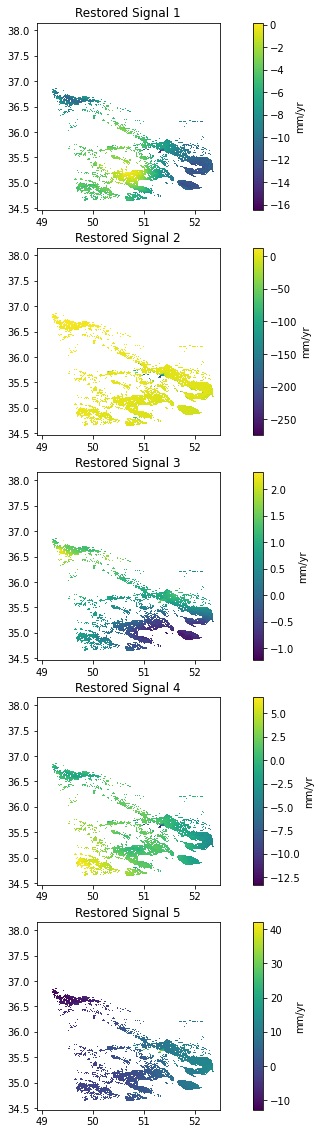

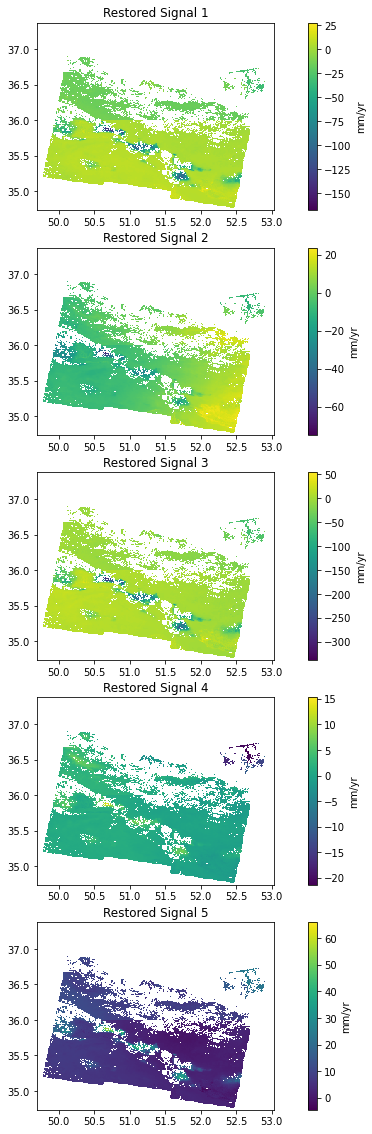

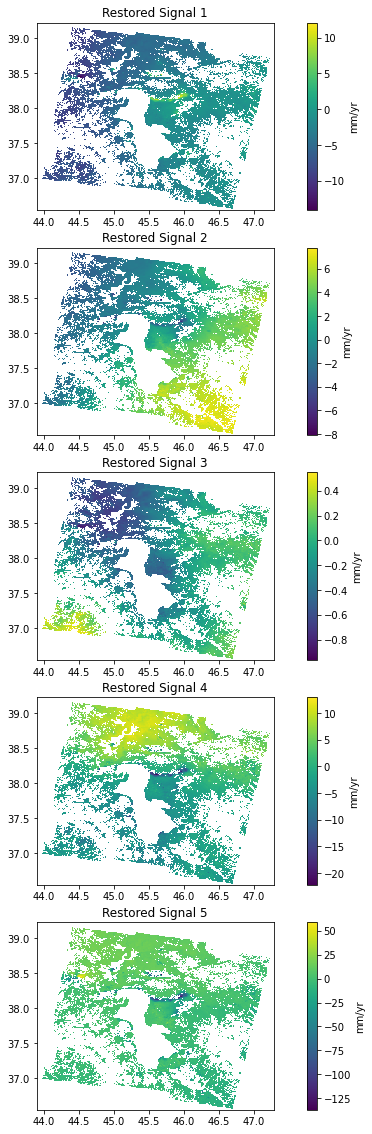

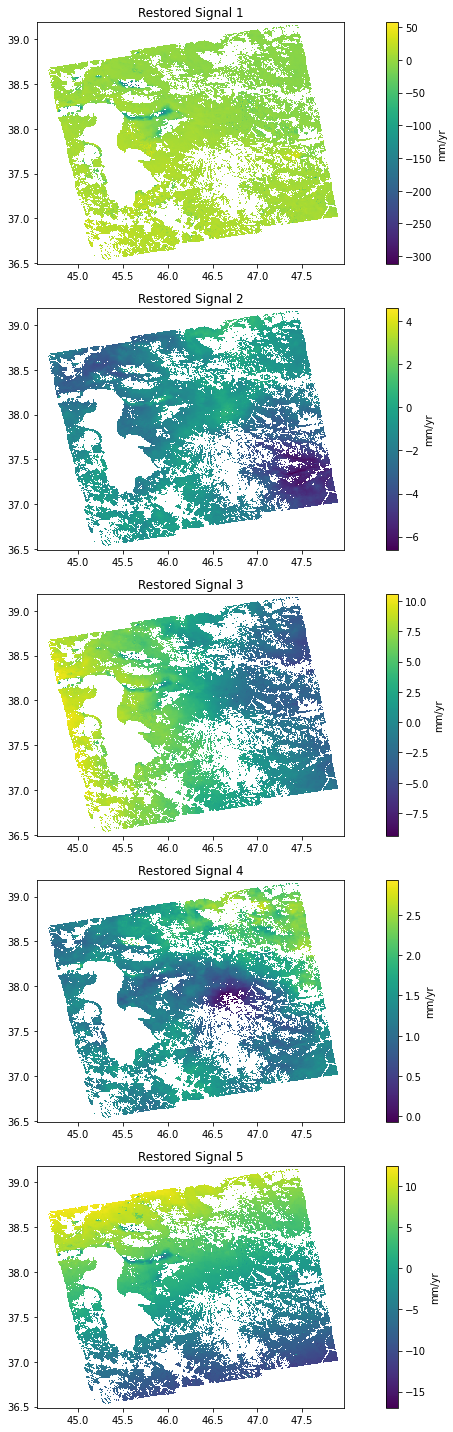

In [20]:
# Find the common indices

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    non_nan_ind = row['non_nan_ind']
    non_zero_ind = row['non_zero_ind']
    restored_signals_outer = row['restored_signals']
    cum = row['cum']
    lon_plot = row['lon']
    lat_plot = row['lat']
    common_indices = np.intersect1d(non_nan_ind, non_zero_ind)
    
    # # Create subplots
    fig, axes = plt.subplots(ncomponents, 1, figsize=(12, 20))
    # # Plot each restored signal in lat, lon on a separate subplot
    for i, (restored_signal, ax) in enumerate(zip(restored_signals_outer, axes), start=1):
        # Create a new matrix with NaNs
        cum_with_nans = np.full((cum.shape[2] * cum.shape[1],), np.nan)

         # Assign values from the restored signal to non-NaN positions
        cum_with_nans[common_indices] = restored_signal[-1]
        cum_with_nans_reshaped = cum_with_nans.reshape((cum.shape[1], cum.shape[2]))
        lon, lat = np.meshgrid(lon_plot, lat_plot)

        # Plot on the subplot
        im = axes[i - 1].imshow(cum_with_nans_reshaped, extent=(lon.min(), lon.max(), lat.min(), lat.max()), cmap='viridis', interpolation ='none')
        axes[i - 1].set_title(f'Restored Signal {i}')
       # Add colorbar
        cbar = plt.colorbar(im, ax=axes[i - 1], label='mm/yr')

plt.tight_layout()
#plt.savefig('descending_component_maps.png', dpi=300)

In [35]:
# keep only subsiding polygon pixels from cum_nozeros_no_nans
# convert polygons shape into a geopandas dataframe
frames_gdf["subsiding_restored_signals"] = ""
frames_gdf["restored_signals_3d"] = ""

gdf_polygons = gpd.read_file(subs_poly_path)

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    non_nan_ind = row['non_nan_ind']
    non_zero_ind = row['non_zero_ind']
    restored_signals_outer = row['restored_signals']
    cum = row['cum']
    lon_plot = row['lon']
    lat_plot = row['lat']

    common_indices = np.intersect1d(non_nan_ind, non_zero_ind)

    cum_with_nans = np.full((cum.shape[0], cum.shape[1], cum.shape[2]), np.nan)

    # Create meshgrid of lon and lat
    lon, lat = np.meshgrid(lon_plot, lat_plot)

    # Flatten lon and lat
    lon_1d = lon.flatten()
    lat_1d = lat.flatten()

    # Create a GeoDataFrame for the flattened lon and lat
    geometry = [Point(lon, lat) for lon, lat in zip(lon_1d, lat_1d)]
    gdf_points = gpd.GeoDataFrame(geometry=geometry, columns=['geometry'])
    gdf_points.crs = "EPSG:4326"
    gdf_points['Latitude'] = lat_1d
    gdf_points['Longitude'] = lon_1d

    # Perform Spatial Join
    joined = gpd.sjoin(gdf_points, gdf_polygons, predicate='within')

    extracted_coordinates = joined[['Latitude', 'Longitude']]

    extracted_indices = joined.index

    # Create a boolean mask for lon and lat arrays
    mask = np.isin(np.arange(lon.size), extracted_indices)

    list = []
    three_d_list = []
    counter = 0
    
    for restored_signal in restored_signals_outer:
        # Convert common_indices to 3D indices i.e. flat indices into a tuple for 3d array
        indices_3d = np.unravel_index(common_indices, cum.shape[1:])

        # Create a copy of cum_with_nans to work with for each restored_signal
        cum_with_nans_copy = cum_with_nans.copy()
        
        # need to make sure a different time series assigned to timestep
        for j in range(restored_signal.shape[0]):
            # Assign values from the restored signal to non-NaN positions
            cum_with_nans_copy[j, indices_3d[0], indices_3d[1]] = restored_signal[j,:]

        # reshape cum_with_nans into time x pixels
        cum_with_nans_pix = cum_with_nans_copy.reshape(cum.shape[0], cum.shape[1] * cum.shape[2])

        #reshape cum_with_nans_pix into 3d to save signals
        restored_signal_3d = cum_with_nans_pix.reshape(cum.shape[0], cum.shape[1], cum.shape[2])
        three_d_list.append(restored_signal_3d)

        # mask cum_with_nans_pix with extracted indices
        masked_cum_with_nans_pix = cum_with_nans_pix * np.where(mask == 0, np.nan, 1)
        list.append(masked_cum_with_nans_pix)
        
    frames_gdf.at[index, 'subsiding_restored_signals'] = list
    frames_gdf.at[index, "restored_signals_3d"] = three_d_list

In [38]:
# remove nans and zeros from each subsiding restored signal
frames_gdf["subsiding_no_nans"] = ""

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    subsiding_restored = row['subsiding_restored_signals']
    no_nans_store = []
    for i, restored_signal in enumerate(subsiding_restored, start=0):
        # Print how many NaNs there are
        nan_indices = np.argwhere(np.isnan(restored_signal))

        # find columns containing NaNs and zeroes
        nan_pixels = np.any(np.isnan(restored_signal), axis=0)

        # create a new data array without nan columns (pixels)
        subsiding_no_nans = restored_signal[:, ~nan_pixels]
        no_nans_store.append(subsiding_no_nans)
    frames_gdf.at[index, 'subsiding_no_nans'] = no_nans_store

In [ ]:
# Create subplots
fig, axes = plt.subplots(ncomponents, 1, figsize=(8, 2 * ncomponents), sharex=True)

row_n = frames_gdf.iloc[0]

frame = row_n['frame']
restored_signals_outer = row_n['subsiding_restored_signals']
dates = row_n['dates']
for i, restored_signal in enumerate(restored_signals_outer, start=1):
    axes[i - 1].grid()
    axes[i - 1].plot(dates, restored_signal[:,2000])
    axes[i - 1].set_title(f"Restored Signal {i}")

plt.xlabel('Time Step')
plt.show()

median_r_squared: [0.002967032779208434, 0.9260710281353642, 0.0013426309759956418, 0.02230678323525777, 0.031696330805830675]
mean_gradient: [-0.0007233686934875523, -0.06287795458122829, -0.00020510556028715296, -0.0010452588421419476, -0.003900950177922327]
index: 1


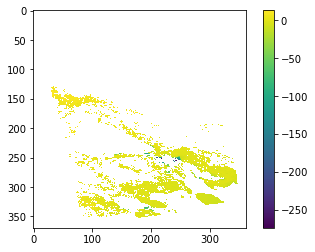

362
028A_05385_191813
median_r_squared: [0.3286501186024581, 0.0040820610280238746, 0.612649644720175, 0.0012542689457091382, 0.045656022590773684]
mean_gradient: [-0.029708429696701427, -0.000430848891310474, -0.05142364730995824, -0.00028321411018150666, -0.005888085609341864]
index: 2


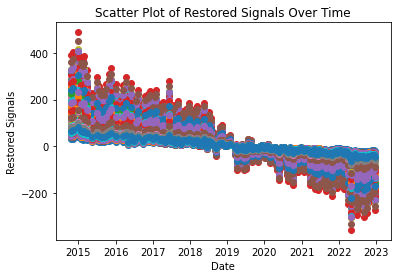

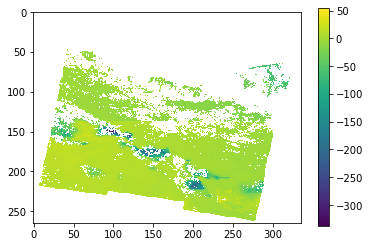

336
035D_05397_131013
median_r_squared: [0.04708624374956955, 0.0036961689740913277, 5.021960190767381e-05, 0.04516384357476267, 0.8853478007860492]
mean_gradient: [-0.0012997133327661984, -0.00020034050194508375, -2.354916246952728e-05, -0.0017597035038656192, -0.04111877770359178]
index: 4


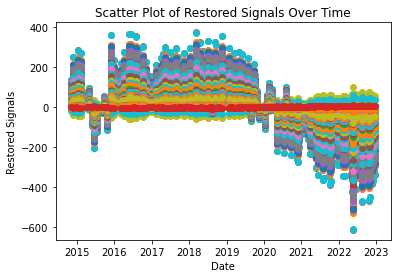

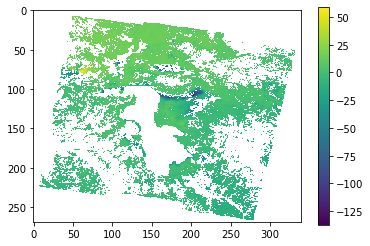

340
079D_05210_131313
median_r_squared: [0.8801593114765641, 0.005339204677130968, 0.007862590802379069, 0.002056003590266957, 0.08207163963363204]
mean_gradient: [-0.047174699187590804, 0.00019179712881467912, 0.0006384907171759575, -0.00046145333663569866, -0.0003410187750025849]
index: 0


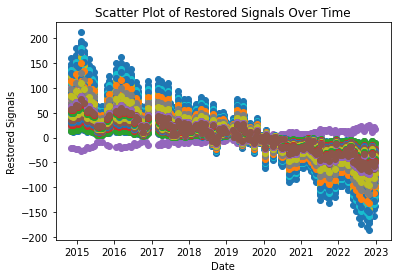

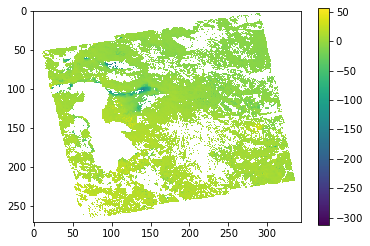

344
174A_05216_131313


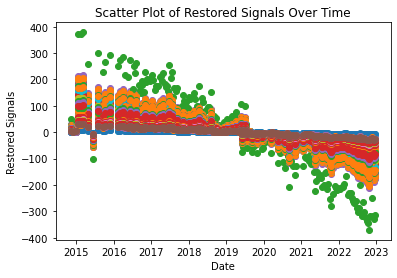

In [69]:
# find most linear!!

frames_gdf["inelastic_restored_signal_3d"] = ""

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    restored_signals = row['subsiding_no_nans']
    dates = row['dates']
    restored_signals_3d = row['restored_signals_3d']
    restored_signals_full = row['restored_signals']
    corner_lat = row['corner_lat']
    corner_lon = row['corner_lon']
    post_lon = row['post_lon']
    post_lat = row['post_lat']
    width = row['width']
    height = row['length']
    lat = row['lat']
    lon = row['lon']
    nc_data = row['imdates']

    # List to store R-squared values for each trend
    mean_gradient = []
    median_r_squared = []
    negative_indices = []
    median_r_squared_negative_gradients = []

    # Convert dates to numerical values
    num_dates = date2num(dates)

    for signal in restored_signals:
        r_squared_values = []
        gradient = []
        # Loop through each trend
        for i in range(signal.shape[1]):
            # Create a time array from 0 to 197 (198 time steps)
            time_steps = dates
    
            # Perform linear regression and calculate R-squared
            slope, _, r_value, _, _ = linregress(num_dates, signal[:,i])

            # Check if the mean gradient is negative
            gradient.append(slope)
    
            # Append R-squared value to the list
            r_squared_values.append(r_value**2)

        # take mean of gradients
        mean_gradient.append(np.mean(gradient))
        # take median of r_squared per IC
        median_r_squared.append(np.median(r_squared_values))
    print('median_r_squared:', median_r_squared)
    print('mean_gradient:', mean_gradient)
    # If mean gradient is negative, find the index of the trend with the maximum R-squared value
    for i in range(len(mean_gradient)):
        if mean_gradient[i] < 0:
            negative_indices.append(i)

    for n in negative_indices:
        median_r_squared_negative_gradients.append(median_r_squared[n])

    max_r_squared_negative_grad = np.max(median_r_squared_negative_gradients)

    # Find the index of max_median_r_squared_negative in median_r_squared
    max_index_in_median_r_squared = np.where(median_r_squared == max_r_squared_negative_grad)[0][0]
    print('index:', max_index_in_median_r_squared)
    # choose the signal
    inelastic_signal = restored_signals_3d[max_index_in_median_r_squared]
    inelastic_signal_subsiding = restored_signals[max_index_in_median_r_squared]

    # Check tiff data chosen correctly
    fig, ax = plt.subplots()
    image = ax.imshow(inelastic_signal[-1,:,:], interpolation = 'none')
    colorbar = fig.colorbar(image)
    plt.show()
    
    inelastic_signal_2d = restored_signals_full[max_index_in_median_r_squared]

    # Check time-series chosen correctly
    fig, ax = plt.subplots()
    for i in range(inelastic_signal_subsiding.shape[1]):
        ax.scatter(dates, inelastic_signal_subsiding[:, i])
        # Customize the plot as needed
        ax.set_xlabel('Date')
        ax.set_ylabel('Restored Signals')
        ax.set_title('Scatter Plot of Restored Signals Over Time')
        
    frames_gdf.at[index, 'inelastic_restored_signal_3d'] = inelastic_signal

    # to save as tif, choose final timestep of 3d restored signal
    final_disp = inelastic_signal[-1,:,:]
    
    # Flip the data vertically
    flipped_data = np.flipud(final_disp)

    # Create a transformation for the GeoTIFF
    transform = from_origin(corner_lon, corner_lat, post_lon, post_lat)

    # output path
    output_path = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/inelastic_tifs/{}_inelastic_component.tif".format(frame)
    
    # Create a rasterio dataset and write the data to it
    with rasterio.open(output_path, 'w', driver='GTiff', height=height, width=width, count=1, dtype='float32', crs='EPSG:4326', transform=transform) as dst:
        # Write the data to the GeoTIFF
        dst.write(flipped_data, 1)

    # also save 3d inelastic dataset as nc
    nc_path = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/inelastic_tifs/{}_inelastic_component.nc".format(frame)

    with nc.Dataset(nc_path, 'w') as file:
        # Create dimensions
        file.createDimension('time', inelastic_signal.shape[0])  # 'None' allows for unlimited size along this dimension
        file.createDimension('latitude', inelastic_signal.shape[1])
        file.createDimension('longitude', inelastic_signal.shape[2])
        # Create variables
        time_var = file.createVariable('time', 'f4', ('time',))
        lat_var = file.createVariable('latitude', 'f4', ('latitude',))
        lon_var = file.createVariable('longitude', 'f4', ('longitude',))
        data_var = file.createVariable('data', 'f4', ('time', 'latitude', 'longitude'))
        # add data to variables
        time_data = nc_data
        lat_data = lat
        lon_data = lon
        data_data = inelastic_signal  

        time_var[:] = time_data
        lat_var[:] = lat_data
        lon_var[:] = lon_data
        data_var[:] = data_data